In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtsrb-german-traffic-sign/Meta.csv
/kaggle/input/gtsrb-german-traffic-sign/Train.csv
/kaggle/input/gtsrb-german-traffic-sign/Test.csv
/kaggle/input/gtsrb-german-traffic-sign/Meta/37.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/35.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/11.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/31.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/4.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/40.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/33.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/9.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/.~lock.ClassesInformation.ods#
/kaggle/input/gtsrb-german-traffic-sign/Meta/14.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/1.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/39.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/20.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/38.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/2.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/10.png


### 📝 Cell 1: Libraries and Data Setup

This cell imports all necessary libraries for Computer Vision and Deep Learning, including **OpenCV** (`cv2`) and **TensorFlow/Keras**. It defines essential constants like the image size and the number of classes.

In [2]:
# Cell 1: Libraries and Data Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 # OpenCV for image processing

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# TensorFlow and Keras for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For Data Augmentation

# --- Define Constants ---
IMAGE_SIZE = (32, 32) 
NUM_CLASSES = 43      

# **CRITICAL: Verify this path matches your Kaggle GTSRB input directory**
BASE_DIR = '/kaggle/input/gtsrb-german-traffic-sign' 
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_CSV_PATH = os.path.join(BASE_DIR, 'Test.csv') 

print(f"Image Size: {IMAGE_SIZE}, Number of Classes: {NUM_CLASSES}")

2025-10-07 17:47:53.186627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759859273.461198      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759859273.538384      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Image Size: (32, 32), Number of Classes: 43


### 🖼️ Cell 2: Data Loading and Preprocessing

This cell loads the training images from class folders, resizes them to 32x32, converts them to grayscale (1 channel) for faster processing, and normalizes the pixel values (0-255 to 0-1). It also splits the data into training and validation sets.

In [3]:
# Cell 2: Data Loading and Preprocessing

def load_data(data_dir):
    """Loads images and labels from the specified directory."""
    images = []
    labels = []
    for class_id in range(NUM_CLASSES):
        path = os.path.join(data_dir, str(class_id))
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                # Load image, convert to grayscale (1 channel), and resize
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
                img = cv2.resize(img, IMAGE_SIZE)
                images.append(img)
                labels.append(class_id)
            except Exception as e:
                print(f"Error loading image: {img_name} - {e}")
    return np.array(images), np.array(labels)

print("Loading training data...")
X_train_raw, y_train_raw = load_data(TRAIN_DIR)
print(f"Loaded {len(X_train_raw)} training images.")

# Reshape and Normalize Images
# Reshape for CNN input: (samples, width, height, channels=1 for grayscale)
X_train = X_train_raw.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0

# One-Hot Encode Labels
y_train = to_categorical(y_train_raw, NUM_CLASSES)

print(f"X_train shape after normalization: {X_train.shape}")

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train_raw
)

print(f"Final training set size: {X_train.shape}")

Loading training data...
Loaded 39209 training images.
X_train shape after normalization: (39209, 32, 32, 1)
Final training set size: (35288, 32, 32, 1)


### 🧱 Cell 3: Building the CNN Model

This cell defines a simple yet effective **Convolutional Neural Network (CNN)** architecture using Keras. The model includes Convolutional layers (`Conv2D`), Pooling (`MaxPooling2D`), and `Dropout` layers to prevent overfitting.

In [4]:
# Cell 3: Building the CNN Model

def build_cnn_model():
    model = Sequential()
    
    # Layer 1: Convolution + Pooling
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25)) 

    # Layer 2: Convolution + Pooling
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())
    
    # Dense Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer (Softmax for multi-class classification)
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    
    return model

cnn_model = build_cnn_model()
print("CNN Model Summary:")
cnn_model.summary()

CNN Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-07 17:50:58.387823: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,915 (1.22 MB)

 Trainable params: 319,915 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

### ⚙️ Cell 4: Training the Model (Data Augmentation Bonus)

The model is trained here. We use **Image Data Augmentation** (`ImageDataGenerator`) as a **Bonus** technique to artificially expand the dataset and prevent overfitting, leading to higher accuracy and better generalization.

In [5]:
# Cell 4: Training the Model (with Data Augmentation Bonus)

# Data Augmentation Setup 
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.15, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1
)
datagen.fit(X_train)

# Start training
EPOCHS = 25 
BATCH_SIZE = 64

print(f"Starting training for {EPOCHS} epochs...")

history = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    shuffle=True
)
print("Training finished.")

Starting training for 25 epochs...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.0945 - loss: 3.4163 - val_accuracy: 0.5496 - val_loss: 1.6458
Epoch 2/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.3975 - loss: 2.0958 - val_accuracy: 0.7707 - val_loss: 0.8839
Epoch 3/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.5197 - loss: 1.5929 - val_accuracy: 0.8490 - val_loss: 0.6671
Epoch 4/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.5938 - loss: 1.3194 - val_accuracy: 0.8898 - val_loss: 0.4633
Epoch 5/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.6462 - loss: 1.1457 - val_accuracy: 0.9102 - val_loss: 0.3811
Epoch 6/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.6750 - loss: 1.0492 - val_accuracy: 0.9347 - val_loss: 0.2809
Epoch 7/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.7063 - loss: 0.9335 - val_accuracy: 0.9470 - val_loss: 0.2452
Epoch 8/25
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.7276 - loss: 0.8749 - val_accurac

### ✅ Cell 5: Final Evaluation and Visualization

This cell loads the separate test set using `Test.csv`, preprocesses it, evaluates the final model performance, and generates the Confusion Matrix to visualize prediction accuracy across all 43 classes.

Loading test data...
Loaded 12630 test images.
Test Accuracy: 96.03%
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


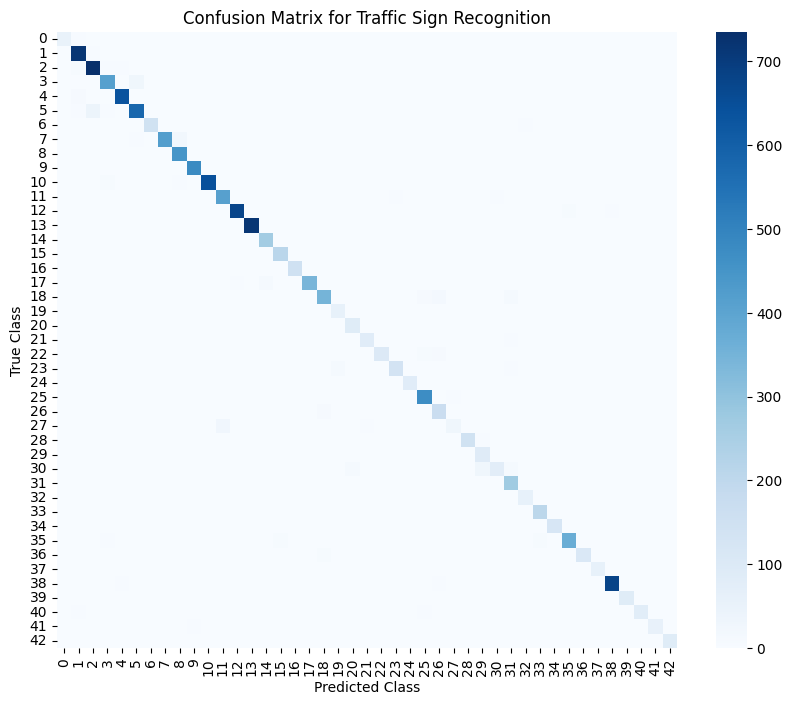

In [6]:
# Cell 5: Evaluation and Visualization

# Load test data and preprocess (using the provided Test.csv)
test_df = pd.read_csv(TEST_CSV_PATH)
X_test_list = []
y_test_list = []

print("Loading test data...")
for index, row in test_df.iterrows():
    # Construct the full image path
    img_path = os.path.join(BASE_DIR, row['Path'])
    
    try:
        # Load, convert to grayscale, and resize
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, IMAGE_SIZE)
        X_test_list.append(img)
        y_test_list.append(row['ClassId'])
    except Exception as e:
        print(f"Error processing image: {img_path} - {e}")
        
X_test = np.array(X_test_list).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
y_test_raw = np.array(y_test_list)

# Normalize Images
X_test = X_test / 255.0

# One-Hot Encode Test Labels
y_test = to_categorical(y_test_raw, NUM_CLASSES)

print(f"Loaded {len(X_test)} test images.")

# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print("=======================================================")
print(f"Test Accuracy: {accuracy*100:.2f}%") 
print("=======================================================")

# Predict classes for the confusion matrix
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test_raw

# Visualize Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues') 
plt.title('Confusion Matrix for Traffic Sign Recognition')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()